In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [324]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


In [325]:
combined=pd.concat([df_train,df_test])

In [326]:
combined['Family_members'] = combined['SibSp'] + combined['Parch']
combined.drop(["Name","SibSp","Parch","Cabin","Ticket"],axis=1,inplace=True)

In [327]:
combined["Title"]=combined["Title"].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
combined["Title"]=combined["Title"].replace(['Mlle','Ms'],'Miss')
combined["Title"]=combined["Title"].replace(['Mme'],'Mrs')

Missing Values handle

In [328]:
combined['Age'] = combined['Age'].fillna(combined.groupby(["Title"])['Age'].transform('mean'))
combined['Fare'] = combined['Fare'].fillna(combined.groupby(["Pclass"])['Fare'].transform('mean'))
combined['Embarked']=combined['Embarked'].fillna("S")

In [329]:
# from sklearn.impute import KNNImputer
# from sklearn.impute import SimpleImputer
# imputer = KNNImputer(n_neighbors=3, weights="uniform")
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# combined["Age"]=pd.DataFrame(imputer.fit_transform(combined["Age"].values.reshape(-1,1)))
# combined["Fare"]=pd.DataFrame(imputer.fit_transform(combined["Fare"].values.reshape(-1,1)))
# combined["Embarked"]=pd.DataFrame(imp.fit_transform(combined["Embarked"].values.reshape(-1,1)))

In [330]:
combined.loc[(combined['Pclass'] == 1),'Pclass_Band'] = 3
combined.loc[(combined['Pclass'] == 3),'Pclass_Band'] = 1
combined.loc[(combined['Pclass'] == 2),'Pclass_Band'] = 2


In [331]:
combined = pd.get_dummies(combined,columns=["Sex","Embarked","Title"])
combined.drop(["Sex_male","Embarked_S"],axis=1,inplace=True)
combined["Title_Mr"]=0

In [332]:
# combined.loc[ combined['Fare'] <= 7.91, 'Fare_Band'] = 0
# combined.loc[(combined['Fare'] > 7.91) & (combined['Fare'] <= 14.454), 'Fare_Band'] = 1
# combined.loc[(combined['Fare'] > 14.454) & (combined['Fare'] <= 31), 'Fare_Band'] = 2
# combined.loc[ combined['Fare'] > 31, 'Fare_Band'] = 3
# combined['Fare_Band'] = combined['Fare_Band'].astype(int)
# combined.drop(['Fare'],axis=1,inplace=True)

In [333]:
combined["Pclass_Band"]=combined["Pclass_Band"].astype(int)
combined.drop(["Pclass"],axis=1,inplace=True)

In [334]:
df_train=combined.iloc[:891,]
df_test=combined.iloc[891:,]

In [335]:
df_train.drop(["PassengerId"],axis=1,inplace=True)
df_train["Survived"]=df_train["Survived"].astype(int)

In [336]:
Y_train = df_train['Survived']
X_train = df_train.drop('Survived', axis=1)

In [337]:
Y_test = df_test['Survived']
X_test = df_test.drop('Survived', axis=1)

In [338]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from operator import itemgetter
import xgboost as xgb
import random
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt

In [339]:
xg = XGBClassifier(learning_rate=0.0, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.001, subsample= 0.8
                  )
xg.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=750, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.001,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [340]:
df_test["Survived"]=xg.predict(df_test.drop(["PassengerId","Survived"],axis=1))

In [342]:
submission=df_test[["PassengerId","Survived"]]

In [343]:
submission.to_csv("submission",index=False)

In [287]:
def run_single(train, test, features, target, random_state=0):    
    eta = 0.4
    max_depth= 6
    subsample = 1
    colsample_bytree =1
    n_estimators=400
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "n_estimators":n_estimators,
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        #"min_chil_weight":min_chil_weight,
        "seed": random_state,
        #"gamma":gamma
        #"num_class" : 22,
    }
    num_boost_round = 3000
    early_stopping_rounds = 100
    test_size = 0.1

   
    
    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index))
    print('Length valid:', len(X_valid.index))
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train, missing=-99)
    dvalid = xgb.DMatrix(X_valid[features], y_valid, missing =-99)

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration+1)
    
    #area under the precision-recall curve
    score = average_precision_score(X_valid[target].values, check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    
    check2=check.round()
    score = precision_score(X_valid[target].values, check2)
    print('precision score: {:.6f}'.format(score))

    score = recall_score(X_valid[target].values, check2)
    print('recall score: {:.6f}'.format(score))
    #xgb.plot_importance(model, height=0.4, ax=ax)
    #imp = get_importance(gbm, features)
    #print('Importance array: ', imp)

    print("Trainin and prediction again test set... ")
    
    d_final = xgb.DMatrix(train[features], train[target], missing =-99)
    
    gbm = xgb.train(params, d_final)
    test_prediction = gbm.predict(xgb.DMatrix(test[features],missing = -99), ntree_limit=gbm.best_iteration+1)
    
    df_test["Survived"]=pd.DataFrame(test_prediction)
    
    xgb.plot_importance(gbm, height=0.4)
    
    #score = average_precision_score(test[target].values, test_prediction)

    #print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
    ############################################ ROC Curve
    

 
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(X_valid[target].values, check)
    roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    ##################################################


    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction,gbm

XGBoost params. ETA: 0.4, MAX_DEPTH: 6, SUBSAMPLE: 1, COLSAMPLE_BY_TREE: 1
Length train: 801
Length valid: 90
[0]	train-auc:0.88699	eval-auc:0.88786
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.90337	eval-auc:0.88477
[2]	train-auc:0.91268	eval-auc:0.88632
[3]	train-auc:0.92151	eval-auc:0.90509
[4]	train-auc:0.93300	eval-auc:0.91847
[5]	train-auc:0.93518	eval-auc:0.91898
[6]	train-auc:0.93703	eval-auc:0.92027
[7]	train-auc:0.94138	eval-auc:0.92232
[8]	train-auc:0.94528	eval-auc:0.92464
[9]	train-auc:0.94722	eval-auc:0.92670
[10]	train-auc:0.94896	eval-auc:0.92721
[11]	train-auc:0.95336	eval-auc:0.92670
[12]	train-auc:0.95467	eval-auc:0.92541
[13]	train-auc:0.95600	eval-auc:0.92747
[14]	train-auc:0.96220	eval-auc:0.92284
[15]	train-auc:0.96494	eval-auc:0.91924
[16]	train-auc:0.96804	eval-auc:0.91770
[17]	train-auc:0.96937	eval-auc:0.92001
[18]	train-auc:0.97152	eval-auc:0.9169

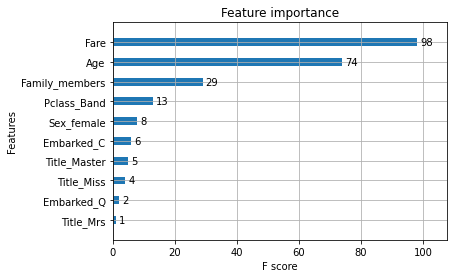

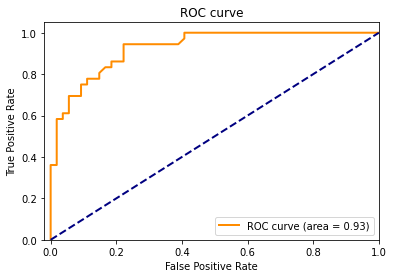

Training time: 0.02 minutes


In [288]:
features = list(df_train.columns.values)
features.remove('Survived')

train, test = train_test_split(df_train, test_size=.1, random_state=random.seed(42))

preds,num_boost_rounds = run_single(df_train, df_test.drop(["PassengerId"],axis=1), features,'Survived',42)

In [295]:
df_test["Survived"]=df_test["Survived"].apply(lambda x: round(x))

In [297]:
submission=df_test[["PassengerId","Survived"]]

In [298]:
submission.to_csv("submission",index=False)

In [246]:
submission = pd.DataFrame({
        "PassengerId": X_test["PassengerId"],
        "Survived": model.predict(X_test.drop(["PassengerId"],axis=1))
    })

In [247]:
submission["Survived"]=submission["Survived"].astype(int)


In [248]:
submission.to_csv('one_more_time.csv', index=False)